In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path
!TZ=America/New_York date

Already up to date.
Wed Mar 27 08:36:42 AM EDT 2024


In [2]:
# for this notebook we also need the PyMySQL module
!pip install PyMySQL

# Pandas complains pymysql connection objects - ignore the warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# our database connection credentials
host = 'testdb.cwy05wfzuxbv.us-east-1.rds.amazonaws.com'
userdb = 'world'
user = 'csc310'
password = 'csc310$is$fun'

Just for reference, the schema of our world database looks as follows:

<img src="https://static.packt-cdn.com/products/9781788390415/graphics/cac1f609-1c45-46d7-b066-d9481ceddf18.png">


**Question**: Cluster the cities in the DB according to their populations.
1. How many clusters are there?
2. What is the average population of the cities in each of the clusters?

First, how many cities are there in our DB?

In [4]:
import pymysql as sql
import pandas as pd

# Open database connection to our test database
db = sql.connect(host=host,
                 user=user,
                 password=password,
                 database=userdb)

# get data using a pandas dataframe
sql_string = \
'''
SELECT
    COUNT(*) as NumberOfCities
FROM
    city
'''

data = pd.read_sql(sql_string, con=db)
print (data)

# disconnect from server
db.close()

   NumberOfCities
0            4079


We have too many cities to cluster.  We'll take a **random sample** of 1000 cities and return the population size of each of the cities in the sample.

**NOTE**: As is usual with DB servers, we want to have the server perform as much of the work as possible.

In [5]:
import pymysql as sql
import pandas as pd

# Open database connection to our test database
db = sql.connect(host=host,
                 user=user,
                 password=password,
                 database=userdb)

# get data using a pandas dataframe
sql_string = \
'''
SELECT
    population as CityPopulation
FROM
    city
ORDER
    BY RAND()
LIMIT
    1000
'''

data = pd.read_sql(sql_string, con=db)
print (data)

# disconnect from server
db.close()

     CityPopulation
0            190900
1            265937
2             90000
3             92239
4            183100
..              ...
995          476668
996          176581
997          227700
998          330259
999          128608

[1000 rows x 1 columns]


Let's try to answer the first question and figure out how many clusters there are.

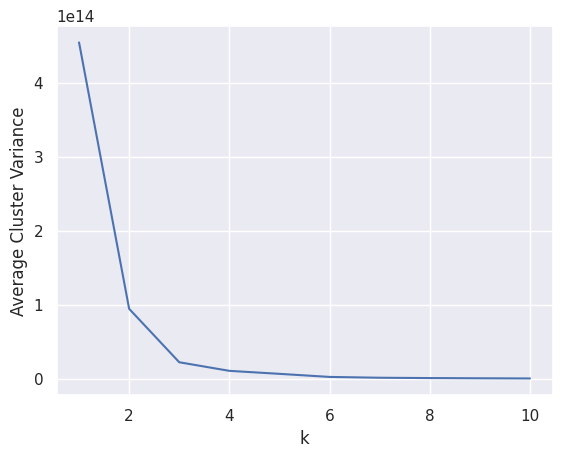

In [6]:
from elbow import plot_elbow

plot_elbow(data)

It is clear from the plot that either k=4 or k=5 represents the optimal number of clusters.

We will pick k=4.

In [13]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, n_init='auto', random_state=1)
model.fit(data)

centers = pd.DataFrame(model.cluster_centers_, columns=data.columns)
centers.sort_values(by='CityPopulation', ascending=False).apply(lambda x:round(x))

,CityPopulation
1,8402391.0
3,3083401.0
2,1290686.0
0,208921.0


We can observe the following:

* Cluster 2 represents mega-cities with an average population of 8mil.
* Cluster 1 represents smaller metropolitan areas with an average population of 3mil.
* Cluster 3 represents cities with an average population of about 1mil.
* Cluster 0 represents smaller cities with an average population of about 200,000.